In [ ]:
# download data: https://drive.google.com/file/d/11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-/view?usp=share_link

# From Scratch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
PATH = 'flower_photos/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 256
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                              PATH,
                                              validation_split=0.2,
                                              subset="training",
                                              seed=123,
                                              image_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [3]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                  PATH,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


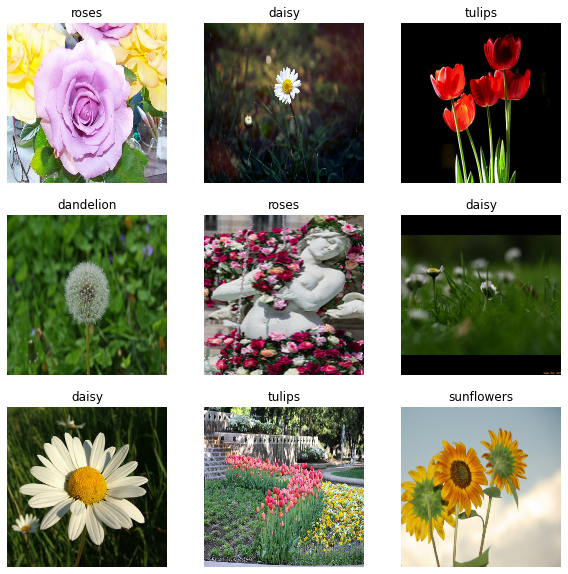

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

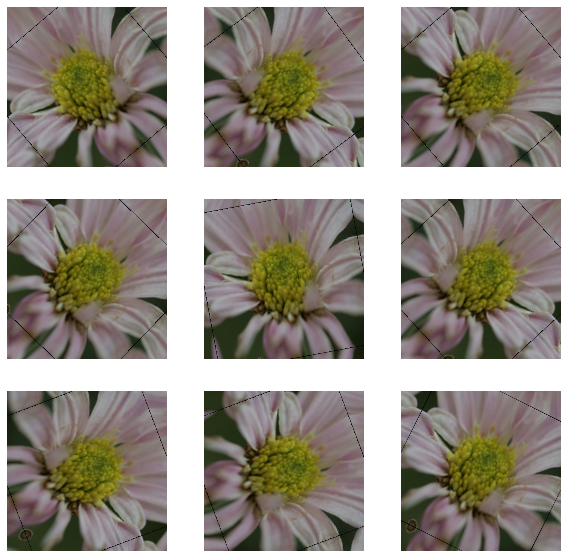

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [9]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(256, 5, 5, 512)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(256, 512)


In [13]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(256, 5)


In [ ]:
# process data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# flattening
flatten = tf.keras.layers.Flatten()

# final layer
prediction_layer = tf.keras.layers.Dense(5)

# construct a new network
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = flatten(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [17]:
len(model.trainable_variables)

28

In [18]:
history_fine = model.fit(train_dataset,
                         epochs=250,
                         validation_data=validation_dataset)

Epoch 1/250
12/12 [==============================] - 14s 1s/step - loss: 1.5627 - accuracy: 0.3208 - val_loss: 1.5606 - val_accuracy: 0.3569
Epoch 2/250
12/12 [==============================] - 10s 839ms/step - loss: 1.2910 - accuracy: 0.4312 - val_loss: 1.2179 - val_accuracy: 0.4850
Epoch 3/250
12/12 [==============================] - 10s 843ms/step - loss: 1.1891 - accuracy: 0.4601 - val_loss: 1.1665 - val_accuracy: 0.4837
Epoch 4/250
12/12 [==============================] - 10s 842ms/step - loss: 1.1440 - accuracy: 0.5003 - val_loss: 1.2281 - val_accuracy: 0.4455
Epoch 5/250
12/12 [==============================] - 10s 846ms/step - loss: 1.1596 - accuracy: 0.4867 - val_loss: 1.0870 - val_accuracy: 0.5123
Epoch 6/250
12/12 [==============================] - 10s 849ms/step - loss: 1.1011 - accuracy: 0.5099 - val_loss: 1.0691 - val_accuracy: 0.5504
Epoch 7/250
12/12 [==============================] - 10s 856ms/step - loss: 1.0456 - accuracy: 0.5637 - val_loss: 1.0488 - val_accuracy: 0.

Epoch 56/250
12/12 [==============================] - 10s 856ms/step - loss: 0.4273 - accuracy: 0.8365 - val_loss: 0.6874 - val_accuracy: 0.7534
Epoch 57/250
12/12 [==============================] - 10s 854ms/step - loss: 0.3920 - accuracy: 0.8457 - val_loss: 0.6912 - val_accuracy: 0.7657
Epoch 58/250
12/12 [==============================] - 10s 864ms/step - loss: 0.3916 - accuracy: 0.8457 - val_loss: 0.7588 - val_accuracy: 0.7602
Epoch 59/250
12/12 [==============================] - 10s 863ms/step - loss: 0.3782 - accuracy: 0.8518 - val_loss: 0.6690 - val_accuracy: 0.7616
Epoch 60/250
12/12 [==============================] - 10s 852ms/step - loss: 0.4202 - accuracy: 0.8375 - val_loss: 0.7141 - val_accuracy: 0.7493
Epoch 61/250
12/12 [==============================] - 10s 862ms/step - loss: 0.4307 - accuracy: 0.8372 - val_loss: 0.6514 - val_accuracy: 0.7698
Epoch 62/250
12/12 [==============================] - 10s 856ms/step - loss: 0.4123 - accuracy: 0.8403 - val_loss: 0.6555 - val_ac

12/12 [==============================] - 10s 860ms/step - loss: 0.0645 - accuracy: 0.9775 - val_loss: 1.1970 - val_accuracy: 0.7847
Epoch 169/250
12/12 [==============================] - 10s 860ms/step - loss: 0.0702 - accuracy: 0.9775 - val_loss: 1.3316 - val_accuracy: 0.7602
Epoch 170/250
12/12 [==============================] - 10s 850ms/step - loss: 0.0832 - accuracy: 0.9697 - val_loss: 1.3700 - val_accuracy: 0.7711
Epoch 171/250
12/12 [==============================] - 10s 857ms/step - loss: 0.0407 - accuracy: 0.9864 - val_loss: 1.4766 - val_accuracy: 0.7629
Epoch 172/250
12/12 [==============================] - 10s 857ms/step - loss: 0.0432 - accuracy: 0.9840 - val_loss: 1.3648 - val_accuracy: 0.7657
Epoch 173/250
12/12 [==============================] - 10s 856ms/step - loss: 0.0597 - accuracy: 0.9802 - val_loss: 1.3425 - val_accuracy: 0.7970
Epoch 174/250
12/12 [==============================] - 10s 863ms/step - loss: 0.0490 - accuracy: 0.9830 - val_loss: 1.1922 - val_accuracy:

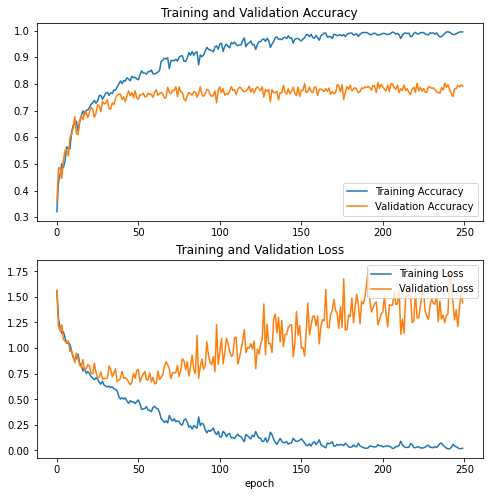

In [20]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()